## Zeitliche Auflösung des Chrom 60 Drahtes im CCA Modus

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from math import floor, ceil, log10
import pandas as pd
import codecs
from operator import sub

# https://stackoverflow.com/questions/3410976/how-to-round-a-number-to-significant-figures-in-python
# https://stackoverflow.com/questions/23207055/rounding-errors-to-1-significant-figure-and-round-values-according-to-number-of
def round_to_n(data, n=1):
    if n != 1:
        return [round(x, -int(floor(log10(np.abs(x)))) + (n - 1)) for x in data]
    else:
        return [round(x, -int(floor(log10(np.abs(x))))) for x in data]

# returns data and error rounded to significance of error
def round_to_reference(data, ref, n):
    ref = round_to_n(ref, n)
    return ([round(x, -int(floor(log10(y))) + (n - 1)) for (x,y) in zip(data, ref)], ref)

rtn = round_to_n
rtr = round_to_reference

def moving_average(x, window_len):
    return np.convolve(x, np.ones(window_len), 'valid') / window_len

# For intersection
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return (array[idx], idx)

# Fit
def Kings_Law (x, const, m, B):
    y = const + m * (x-B)**4
    return y

# Returns flow velocity and uncertainty
def U_Düse_in_v(U):
    return (U*4.749, U*0.031)

label_size = 20
plt.rcParams.update({'font.size': label_size, 'legend.title_fontsize': 18, 'legend.fontsize': 18, "axes.labelsize": label_size, "xtick.labelsize": label_size, 
"ytick.labelsize": label_size, "axes.labelpad": 4, "lines.markersize": 10, "lines.linewidth": 2})

In [27]:
with open("R/CCA_resolution/3.3.2_Aufl_CCA_1_x.txt", "r") as file:
    data_backup = np.array(file.read().splitlines(), float)

In [28]:
t_80_f_vec, t_90_f_vec, t_95_f_vec = [], [], []
t_80_s_vec, t_90_s_vec, t_95_s_vec = [], [], []
t_f_0_vec, t_s_0_vec = [], []


### Gesamte Zeitserie

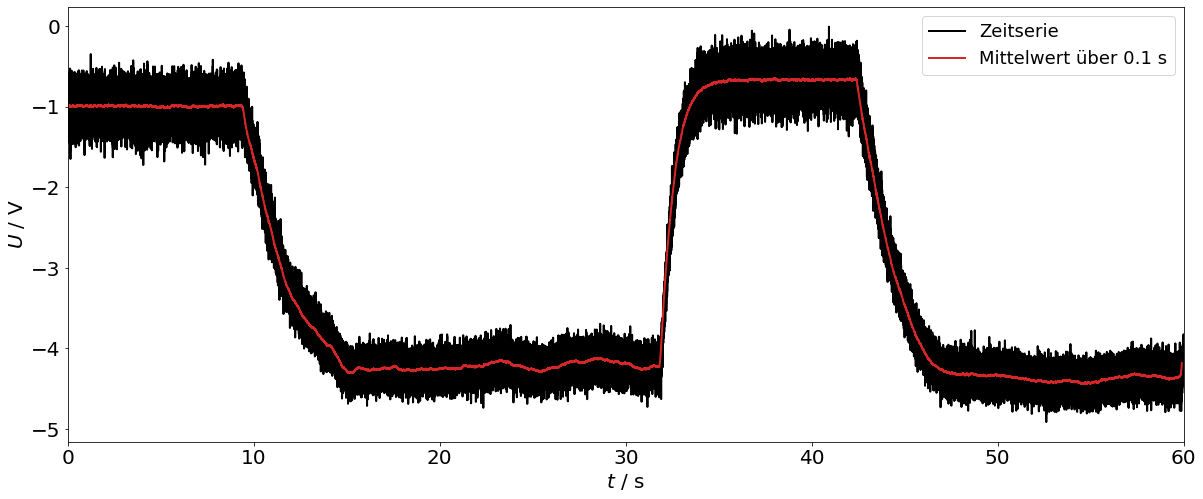

In [29]:
data = data_backup
# Convert time to num data points
def c(time, o=0, s_freq = 10000):
    # o = offset
    return int((time+o)*s_freq)
# Inverse function
def ci(num, s_freq = 10000):
    return (num/s_freq)
# Inverse function and round
def cir(num, s_freq = 10000):
    return np.round((num/s_freq),2)

s_freq= 10000 # Sampling frequency
# Beginning and end of time series plot
tb = c(0)
te = c(60)
time = np.arange(0, len(data)/s_freq, 1/s_freq)
time = time[tb:te]

fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(time, data[tb:te], c="black", label="Zeitserie")

t_avg = 1000
data_avg = moving_average(data[tb:te], t_avg)
ax.plot(time[0:len(data_avg)], data_avg, c="C3", label=f"Mittelwert über {t_avg/s_freq} s")
ax.set_xlabel("$t$ / s")
ax.set_ylabel("$U$ / V")
ax.set_xlim(0,60)
ax.legend()
plt.savefig("Abb/Aufl_3_2_Zeitserie_gesamt.png")

# Fallende Flanke - Funktion

In [30]:
def fallende_flanke(t_beginning, t_end, U_b_start, U_b_end, U_e_start, U_e_end, file_name="Test_Save", save=False, dU=0.01):
    # Begrenze Zeitserie, das hilft später beim Schnittpunkt finden und vereinfacht Index->Zeit Konvertierung
    data = data_backup
    s_freq= 10000 # Sampling frequency
    # Beginning and end of time series plot

    tb = c(t_beginning)
    te = c(t_end)
    time = np.arange(0, len(data)/s_freq, 1/s_freq)
    time = time[tb:te]
    data = data[tb:te]

    fig, ax = plt.subplots(1,1,figsize=(20,8))
    ax.plot(time, data, c="black", label="Zeitserie")

    t_avg = 1000
    data_avg = moving_average(data, t_avg)
    ax.plot(time[0:len(data_avg)], data_avg, c="C3", label=f"Mittelwert über {t_avg/s_freq} s")

    # Hier muss man immer c(x) bei x, 5 abziehen, weil arrays ab 5 Sekunden anfangen und Index
    # der Array sonst nicht richtig berechent wird
    # Start
    U_b = np.round(np.mean(data[U_b_start:c(U_b_end)-tb]),3)
    ax.axhline(U_b, ls="--") # label= "$U_{start}$"+f" = {U_b}"

    # End
    U_e = np.round(np.mean(data[c(U_e_start)-tb:c(U_e_end)-tb]),3)
    ax.axhline(U_e, ls="--") # label= "$U_{end}$"+f" = {U_e}"

    # Fall until x%
    U_delta = np.abs(U_e-U_b)
    U_f_80 = U_b-U_delta*0.8
    (_, t_f_80_idx) = find_nearest(data_avg, U_f_80)
    ax.axvline(ci(t_f_80_idx+tb), ls="--", label= "$U_{80}$"+f" = {U_f_80:.2f} V", c="C4")

    U_f_90 = U_b-U_delta*0.9
    (_, t_f_90_idx) = find_nearest(data_avg, U_f_90)
    ax.axvline(ci(t_f_90_idx+tb), ls="--", label= "$U_{90}$"+f" = {U_f_90:.2f} V", c="C4")

    U_f_95 = U_b-U_delta*0.95
    (_, t_f_95_idx) = find_nearest(data_avg, U_f_95)
    ax.axvline(ci(t_f_95_idx+tb), ls="--", label= "$U_{95}$"+f" = {U_f_95:.2f} V", c="C4")

    # First manual method
    # ts = c(9.4) # Start of drop off/edge
    # (t_f_0, t_f_0_idx) = find_nearest(data_avg[ts-tb:], U_b)
    # ax.axvline(ci(t_f_0_idx+ts), ls="--", label= "$U_{drop}$"+f" = {U_f_0}", c="C1")

    # Automatic --> First time difference to start value is greater than 1%
    U_f_0 = U_b-U_delta*dU
    (_, t_f_0_idx) = find_nearest(data_avg, U_f_0)
    ax.axvline(ci(t_f_0_idx+tb), ls="--", label= "Start Messung", c="C1")

    ax.set_xticks(list(ax.get_xticks())+ [5])

    ax_top = ax.secondary_xaxis("top")
    t_f_0, t_80_f, t_90_f, t_95_f = cir(t_f_0_idx+tb), cir(t_f_80_idx+tb), cir(t_f_90_idx+tb), cir(t_f_95_idx+tb)
    t_f_0_vec.append(t_f_0), t_80_f_vec.append(t_80_f-t_f_0), t_90_f_vec.append(t_90_f-t_f_0), t_95_f_vec.append(t_95_f-t_f_0)

    extra_ticks_x1 = np.round([t_f_0, t_80_f, t_90_f, t_95_f],2)
    ax_top.set_xticks(extra_ticks_x1)
    ax_top.set_xticklabels(extra_ticks_x1, rotation=45, ha="left", va="center",rotation_mode="anchor")
    ax_top.get_xticklabels()[0].set_color("C1")
    for i in [1,2,3]:
        ax_top.get_xticklabels()[i].set_color("C4")


    ax_right = ax.secondary_yaxis("right")
    extra_ticks_y = np.round([U_b, U_e],2)
    ax_right.set_yticks(extra_ticks_y)
    for ax_label in ax_right.get_yticklabels():
        ax_label.set_color("C0")


    ax.set_xlabel("$t$ / s")
    ax.set_ylabel("$U$ / V")
    ax.set_xlim(t_beginning, t_end)
    ax.legend()
    if save: plt.savefig(file_name)

In [31]:
def steigende_flanke(t_beginning, t_end, U_b_start, U_b_end, U_e_start, U_e_end, file_name="Test_Save", save=False, dU=0.01):
    # Begrenze Zeitserie, das hilft später beim Schnittpunkt finden und vereinfacht Index->Zeit Konvertierung
    data = data_backup
    s_freq= 10000 # Sampling frequency
    # Beginning and end of time series plot

    tb = c(t_beginning)
    te = c(t_end)
    time = np.arange(0, len(data)/s_freq, 1/s_freq)
    time = time[tb:te]
    data = data[tb:te]

    fig, ax = plt.subplots(1,1,figsize=(20,8))
    ax.plot(time, data, c="black", label="Zeitserie")

    t_avg = 1000
    data_avg = moving_average(data, t_avg)
    ax.plot(time[0:len(data_avg)], data_avg, c="C3", label=f"Mittelwert über {t_avg/s_freq} s")

    # Hier muss man immer c(x) bei x, 5 abziehen, weil arrays ab 5 Sekunden anfangen und Index
    # der Array sonst nicht richtig berechent wird
    # Start
    U_b = np.round(np.mean(data[U_b_start:c(U_b_end)-tb]),3)
    ax.axhline(U_b, ls="--") # label= "$U_{start}$"+f" = {U_b}"

    # End
    U_e = np.round(np.mean(data[c(U_e_start)-tb:c(U_e_end)-tb]),3)
    ax.axhline(U_e, ls="--") # label= "$U_{end}$"+f" = {U_e}"

    # Rise until x%
    U_delta = np.abs(U_e-U_b)
    U_f_80 = U_b+U_delta*0.8
    (t_f_80, t_f_80_idx) = find_nearest(data_avg, U_f_80)
    ax.axvline(ci(t_f_80_idx+tb), ls="--", label= "$U_{80}$"+f" = {U_f_80:.2f} V", c="C4")

    U_f_90 = U_b+U_delta*0.9
    (t_f_90, t_f_90_idx) = find_nearest(data_avg, U_f_90)
    ax.axvline(ci(t_f_90_idx+tb), ls="--", label= "$U_{90}$"+f" = {U_f_90:.2f} V", c="C4")

    U_f_95 = U_b+U_delta*0.95
    (t_f_95, t_f_95_idx) = find_nearest(data_avg, U_f_95)
    ax.axvline(ci(t_f_95_idx+tb), ls="--", label= "$U_{95}$"+f" = {U_f_95:.2f} V", c="C4")

    # Automatic --> First time difference to start value is greater than 1%
    U_f_0 = U_b+U_delta*dU
    (t_f_0, t_f_0_idx) = find_nearest(data_avg, U_f_0)
    ax.axvline(ci(t_f_0_idx+tb), ls="--", label= "Start Messung", c="C1")

    ax_top = ax.secondary_xaxis("top")
    t_f_0, t_80_f, t_90_f, t_95_f = cir(t_f_0_idx+tb), cir(t_f_80_idx+tb), cir(t_f_90_idx+tb), cir(t_f_95_idx+tb)
    t_s_0_vec.append(t_f_0), t_80_s_vec.append(t_80_f-t_f_0), t_90_s_vec.append(t_90_f-t_f_0), t_95_s_vec.append(t_95_f-t_f_0)

    extra_ticks_x2 = np.round([t_f_0, t_80_f, t_90_f, t_95_f],2)

    ax_top.set_xticks(extra_ticks_x2)
    ax_top.set_xticklabels(extra_ticks_x2, rotation=45, ha="left", va="center",rotation_mode="anchor")
    ax_top.get_xticklabels()[0].set_color("C1")
    for i in [1,2,3]:
        ax_top.get_xticklabels()[i].set_color("C4")

    ax_right = ax.secondary_yaxis("right")
    extra_ticks_y = np.round([U_b, U_e],2)
    ax_right.set_yticks(extra_ticks_y)
    for ax_label in ax_right.get_yticklabels():
        ax_label.set_color("C0")

    # extra_ticks.extend(ax.get_xticks())
    # plt.setp([tick.label2 for tick in ax.xaxis.get_major_ticks()], rotation=45,
    #          ha="left", va="center",rotation_mode="anchor")

    ax.set_xlabel("$t$ / s")
    ax.set_ylabel("$U$ / V")
    ax.set_xlim(t_beginning,t_end)
    ax.legend()
    if save: plt.savefig(file_name)

### Abfallende Flanke

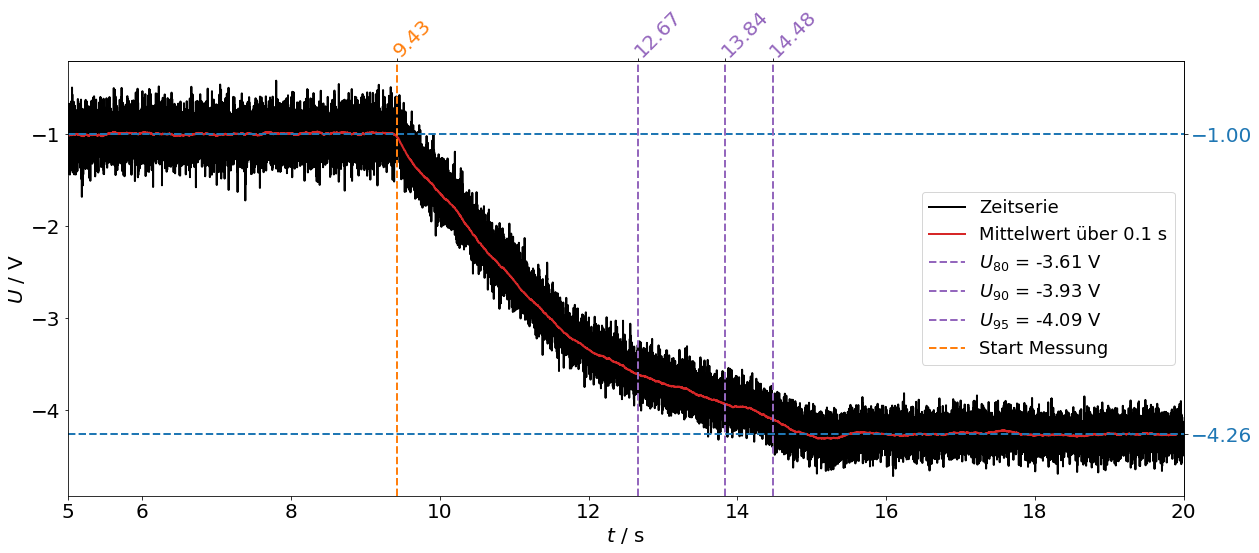

In [32]:
# def fallende_flanke(t_beginning, t_end, U_b_start, U_b_end, U_e_start, U_e_end):
fallende_flanke(5, 20, 0, 9, 16, 20, save=True, file_name="Abb/Aufl_3_2_Zeitserie_fallend.png")

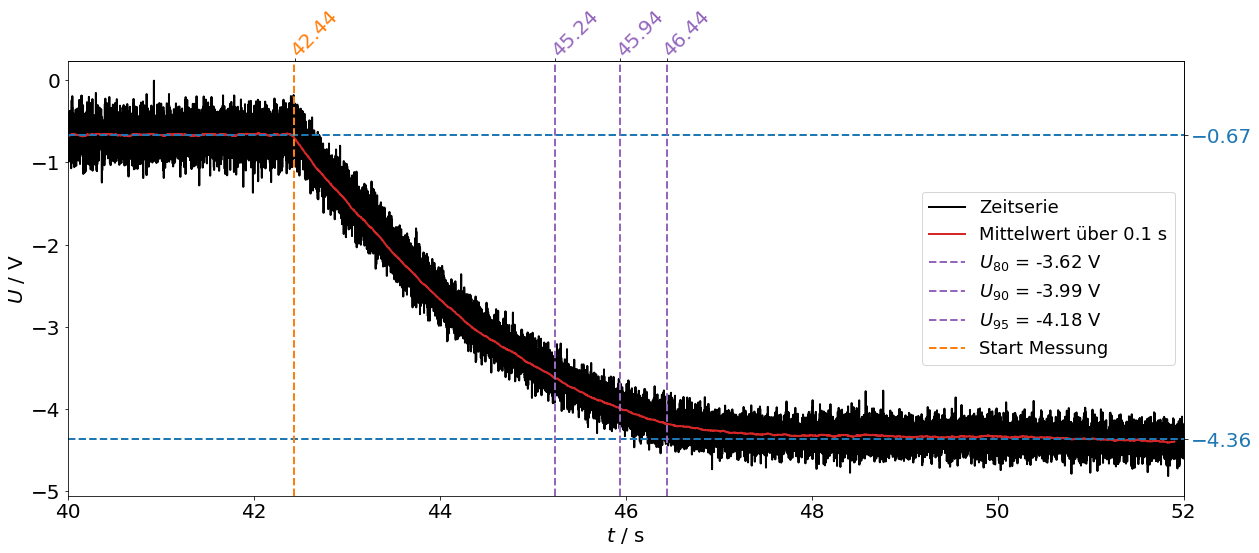

In [33]:
# def steigende_flanke(t_beginning, t_end, U_b_start, U_b_end, U_e_start, U_e_end):
fallende_flanke(40, 52, 40, 42, 50, 52)

### Steigende Flanke

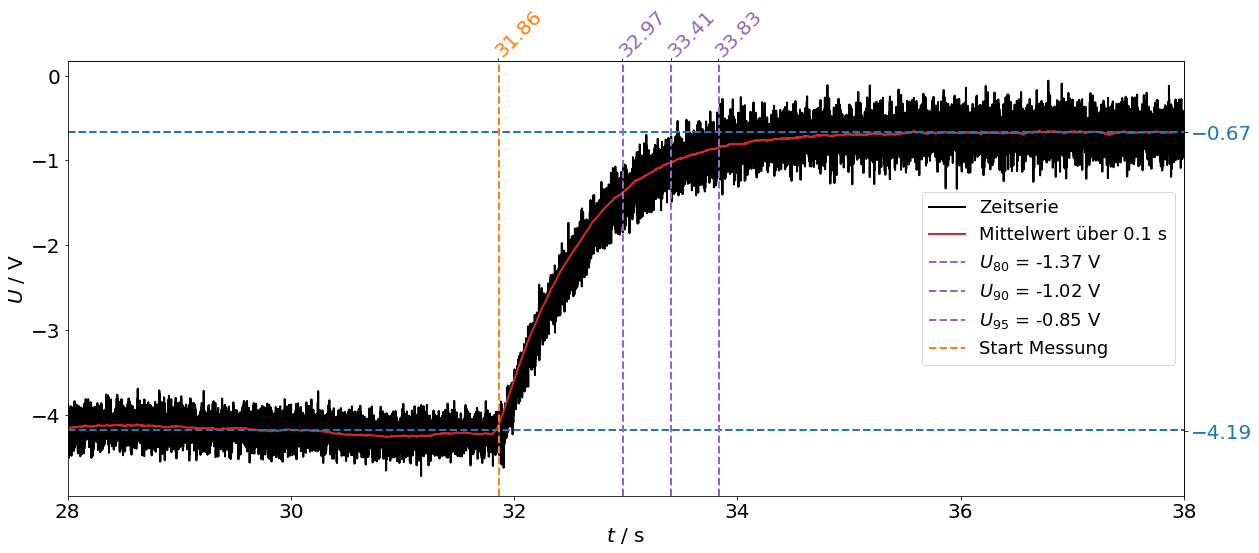

In [34]:
# def steigende_flanke(t_beginning, t_end, U_b_start, U_b_end, U_e_start, U_e_end):
steigende_flanke(28, 38, 28, 31.8, 36, 38, file_name="Abb/Aufl_3_2_Zeitserie_steigend.png", save=True, dU=0.02)

### Alles eingezeichnet

<ipython-input-35-e0ceaa7958b2>:53: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("Abb/Aufl_3_2_Zeitserie_gesamt_eingezeichnet.png")


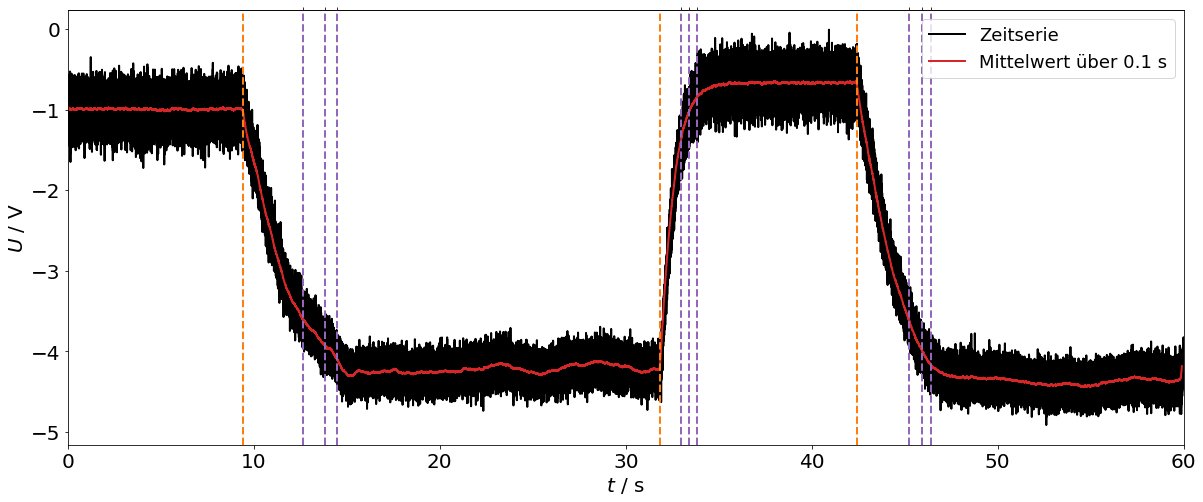

In [35]:
data = data_backup
# Convert time to num data points
def c(time, o=0, s_freq = 10000):
    # o = offset
    return int((time+o)*s_freq)
# Inverse function
def ci(num, s_freq = 10000):
    return (num/s_freq)

s_freq= 10000 # Sampling frequency
# Beginning and end of time series plot
tb = c(0)
te = c(60)
time = np.arange(0, len(data)/s_freq, 1/s_freq)
time = time[tb:te]

fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(time, data[tb:te], c="black", label="Zeitserie")

t_avg = 1000
data_avg = moving_average(data[tb:te], t_avg)
ax.plot(time[0:len(data_avg)], data_avg, c="C3", label=f"Mittelwert über {t_avg/s_freq} s")

ax_top = ax.secondary_xaxis("top")
for vec in [t_f_0_vec, t_80_f_vec, t_90_f_vec, t_95_f_vec ,t_s_0_vec, t_80_s_vec, t_90_s_vec, t_95_s_vec]:
    vec = np.array(vec)

t_80_f_vec = [sum(i) for i in zip(t_80_f_vec, t_f_0_vec)]
t_90_f_vec = [sum(i) for i in zip(t_90_f_vec, t_f_0_vec)]
t_95_f_vec = [sum(i) for i in zip(t_95_f_vec, t_f_0_vec)]

t_80_s_vec = [sum(i) for i in zip(t_80_s_vec, t_s_0_vec)]
t_90_s_vec = [sum(i) for i in zip(t_90_s_vec, t_s_0_vec)]
t_95_s_vec = [sum(i) for i in zip(t_95_s_vec, t_s_0_vec)]


ticks_percent = list(t_80_f_vec) + list(t_90_f_vec) +  list(t_95_f_vec) + list(t_80_s_vec) + list(t_90_s_vec) +  list(t_95_s_vec)
ticks_flanken = t_f_0_vec + t_s_0_vec

ax_top.set_xticks(ticks_percent)
ax_top.set_xticklabels("", rotation=45, ha="left", va="center",rotation_mode="anchor")

for i in ticks_flanken:
    ax.axvline(i, ls="--", c="C1")

for i in ticks_percent:
    ax.axvline(i, ls="--", c="C4")

ax.set_xlabel("$t$ / s")
ax.set_ylabel("$U$ / V")
ax.set_xlim(0,60)
ax.legend()
plt.savefig("Abb/Aufl_3_2_Zeitserie_gesamt_eingezeichnet.png")

# Andere Daten

In [36]:
with open("R/CCA_resolution/3.3.2_Aufl_CCA_2.txt", "r") as file:
    data_backup = np.array(file.read().splitlines(), float)

In [37]:
# Wenn man die Tabelle am Ende will, dann das hier ausgrauen. 
# Wenn man den Plot mit allen richtigen Strichen haben will (ohne die vom Plot davor) dann ohne Kommentar
# t_80_f_vec, t_90_f_vec, t_95_f_vec = [], [], []
# t_80_s_vec, t_90_s_vec, t_95_s_vec = [], [], []
# t_f_0_vec, t_s_0_vec = [], []

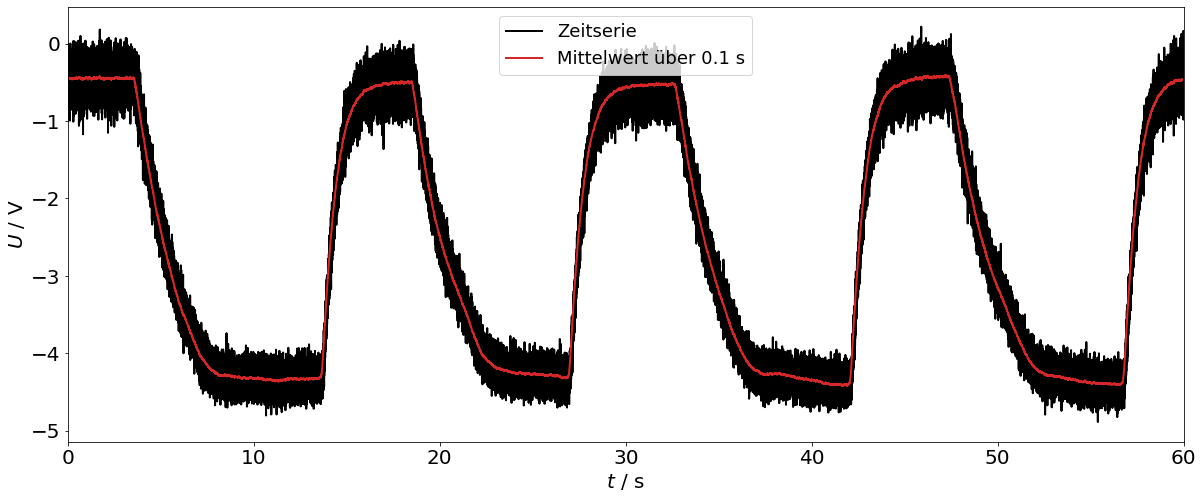

In [38]:
data = data_backup
# Convert time to num data points
def c(time, o=0, s_freq = 10000):
    # o = offset
    return int((time+o)*s_freq)
# Inverse function
def ci(num, s_freq = 10000):
    return (num/s_freq)

s_freq= 10000 # Sampling frequency
# Beginning and end of time series plot
tb = c(0)
te = c(60)
time = np.arange(0, len(data)/s_freq, 1/s_freq)
time = time[tb:te]

fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(time, data[tb:te], c="black", label="Zeitserie")

t_avg = 1000
data_avg = moving_average(data[tb:te], t_avg)
ax.plot(time[0:len(data_avg)], data_avg, c="C3", label=f"Mittelwert über {t_avg/s_freq} s")
ax.set_xlabel("$t$ / s")
ax.set_ylabel("$U$ / V")
ax.set_xlim(0,60)
ax.legend()
plt.savefig("Abb/Aufl_3_2_Zeitserie_Nr2_gesamt.png")

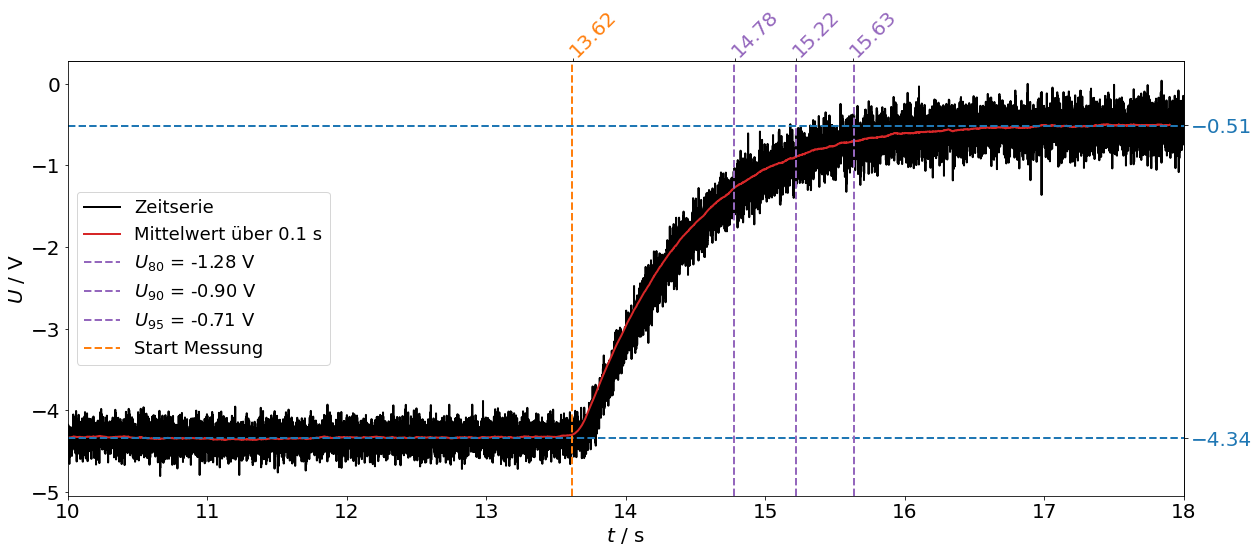

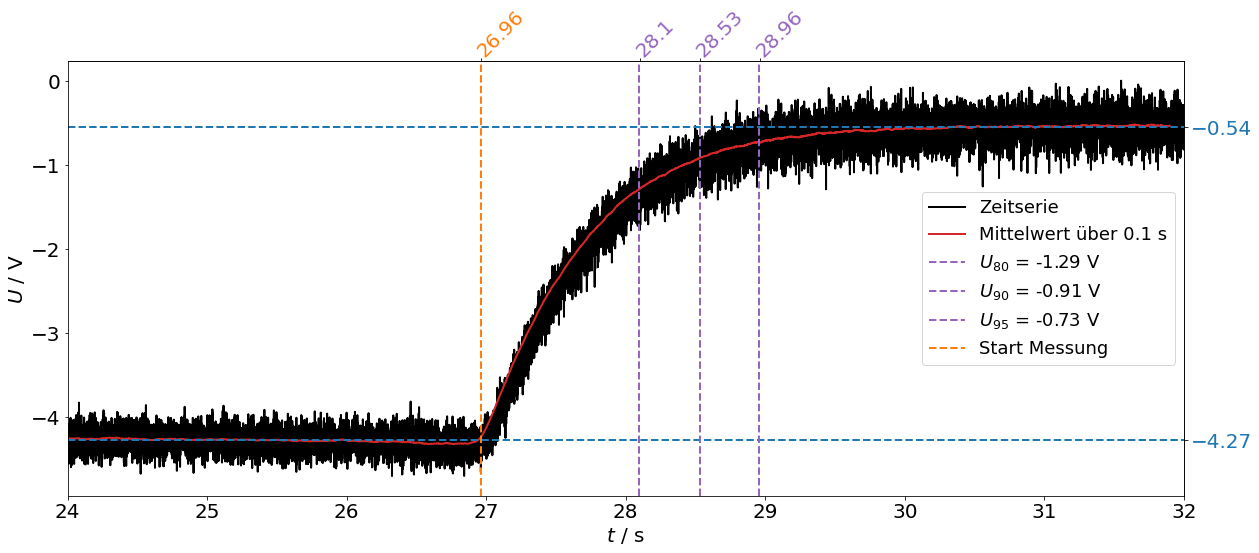

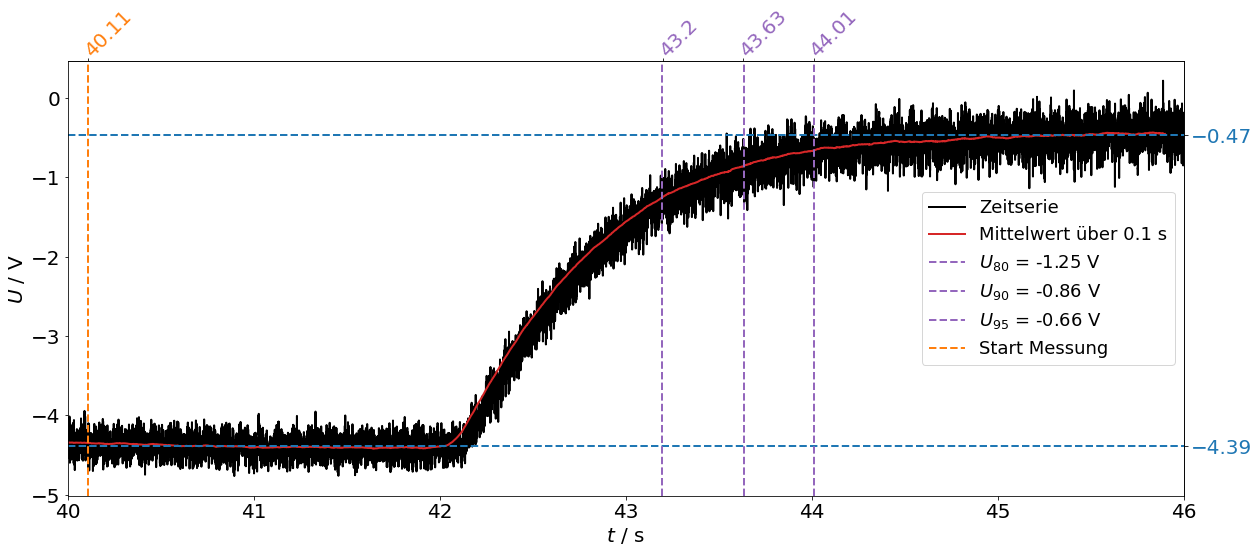

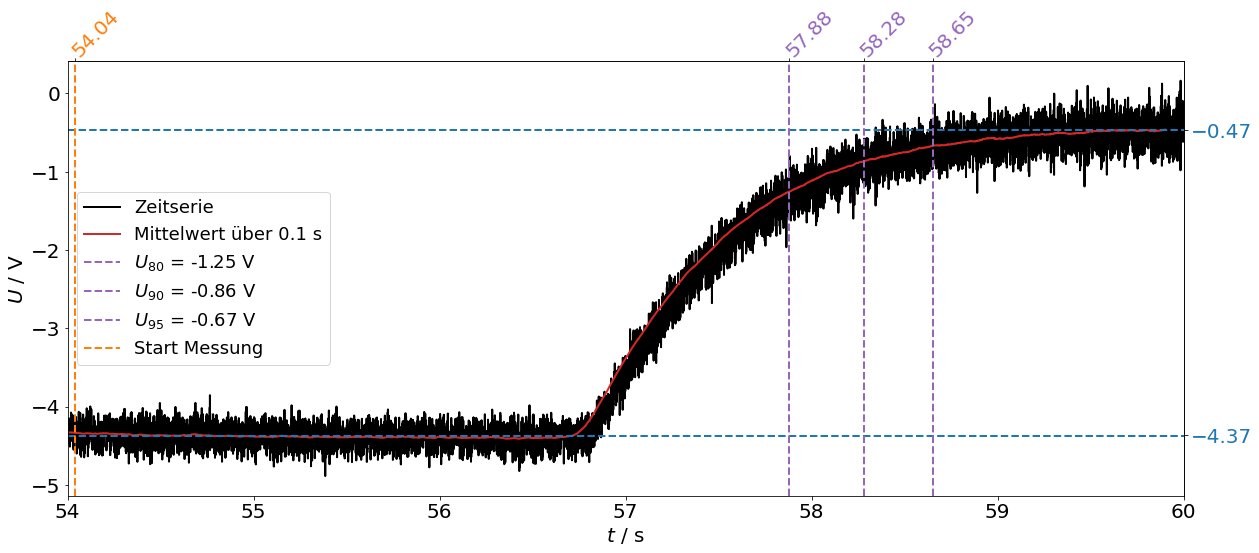

In [39]:
steigende_flanke(10,18,10,13,17,18) 
steigende_flanke(24,32,24,26,30,32)
steigende_flanke(40,46,40,42,45,46)
steigende_flanke(54,60,54,56,59.5,60)

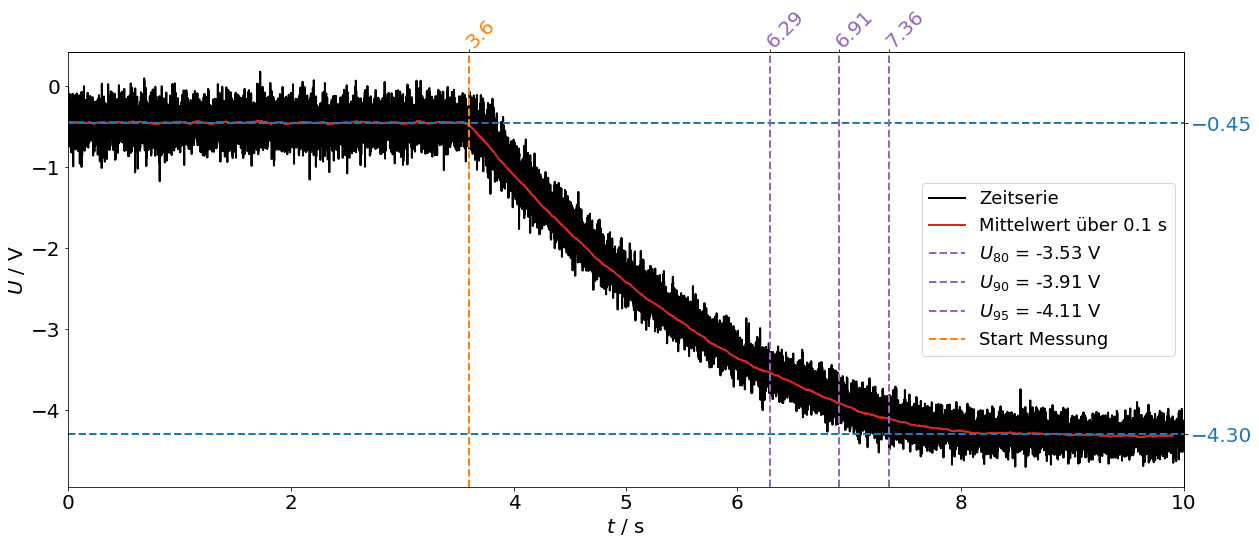

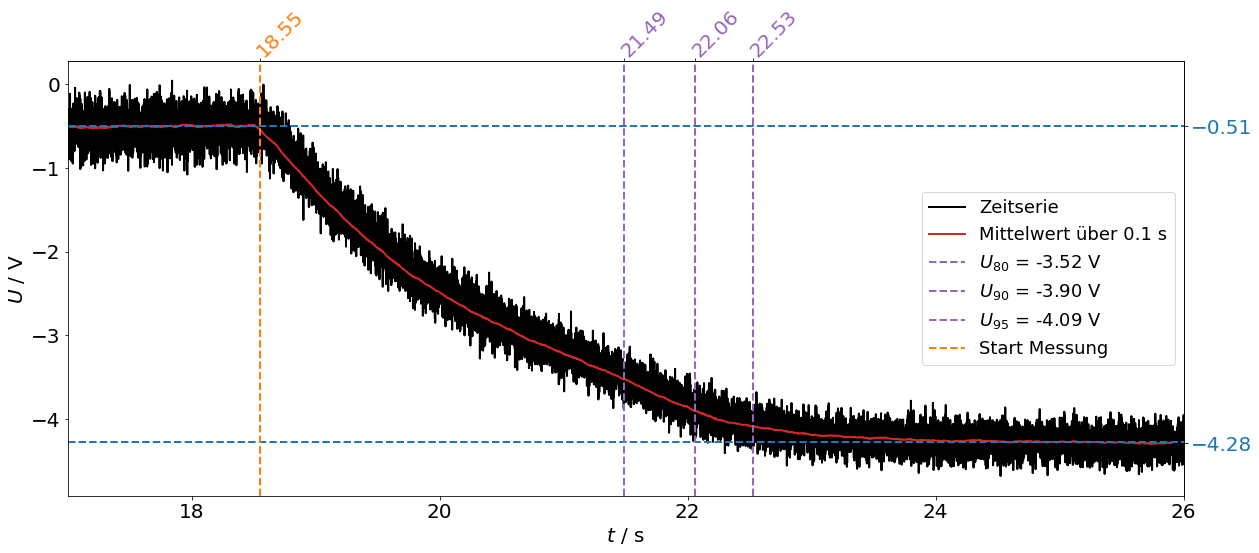

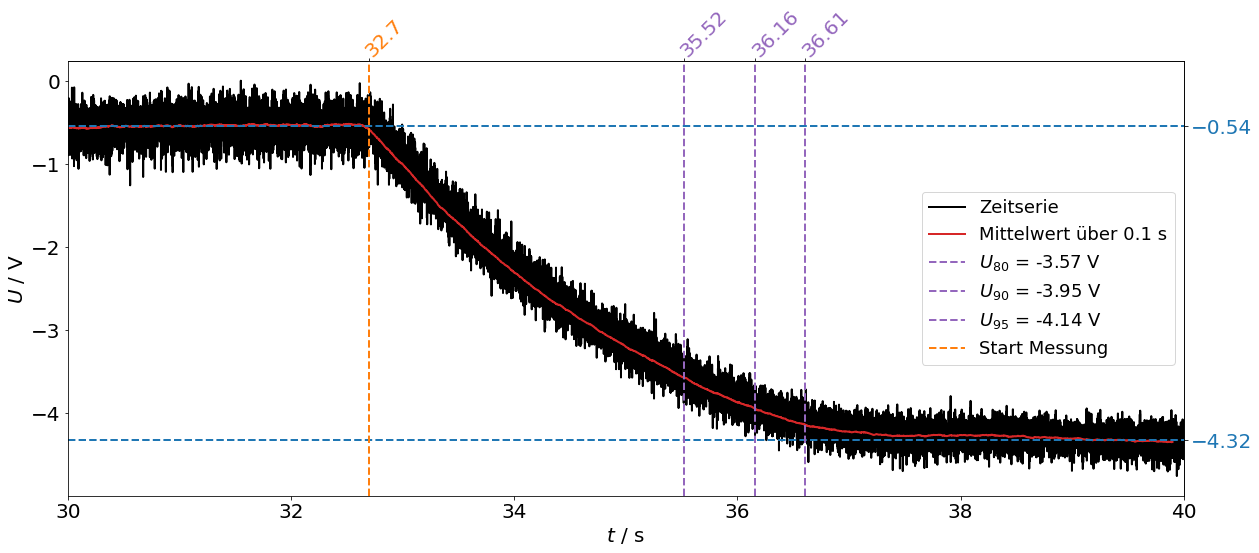

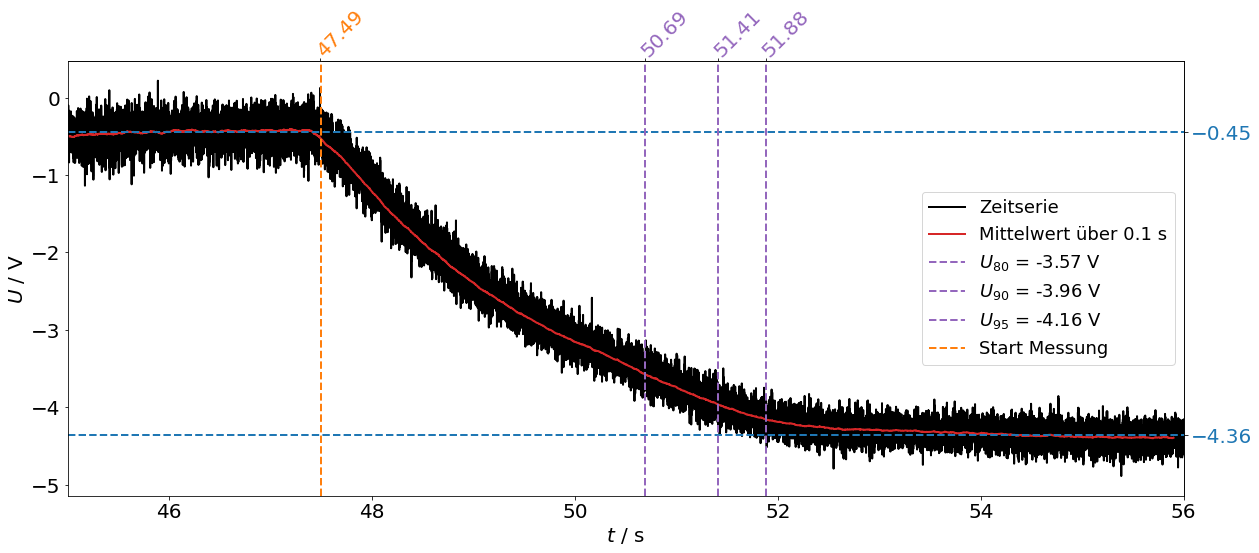

In [40]:
fallende_flanke(0,10,0,3,8,10)
fallende_flanke(17,26,17,18.5,25,26)
fallende_flanke(30,40,30,31.5,39,40)
fallende_flanke(45,56,45,47.3,53,56,dU=0.02)

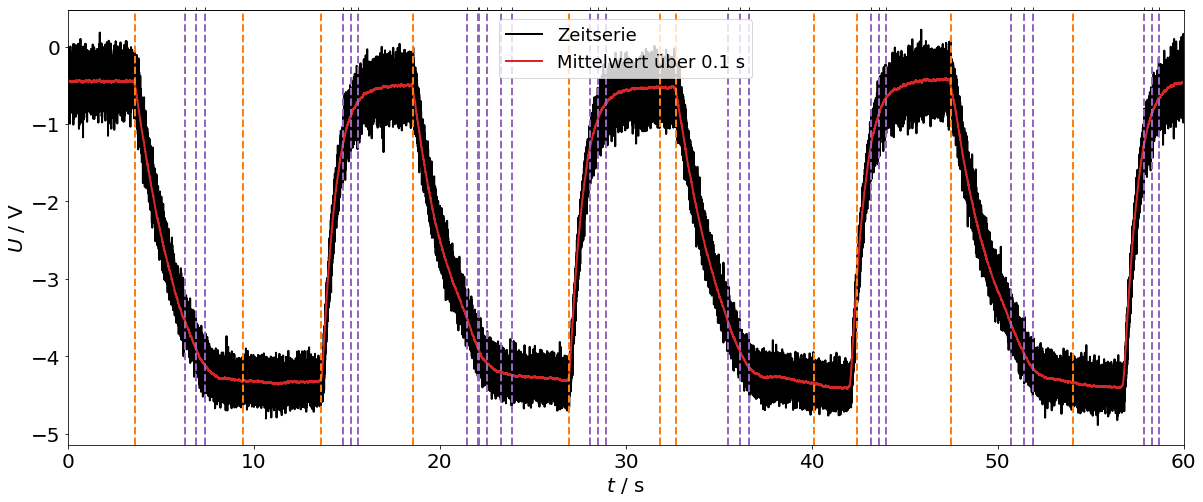

In [41]:
data = data_backup
# Convert time to num data points
def c(time, o=0, s_freq = 10000):
    # o = offset
    return int((time+o)*s_freq)
# Inverse function
def ci(num, s_freq = 10000):
    return (num/s_freq)

s_freq= 10000 # Sampling frequency
# Beginning and end of time series plot
tb = c(0)
te = c(60)
time = np.arange(0, len(data)/s_freq, 1/s_freq)
time = time[tb:te]

fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(time, data[tb:te], c="black", label="Zeitserie")

t_avg = 1000
data_avg = moving_average(data[tb:te], t_avg)
ax.plot(time[0:len(data_avg)], data_avg, c="C3", label=f"Mittelwert über {t_avg/s_freq} s")

ax_top = ax.secondary_xaxis("top")
for vec in [t_f_0_vec, t_80_f_vec, t_90_f_vec, t_95_f_vec ,t_s_0_vec, t_80_s_vec, t_90_s_vec, t_95_s_vec]:
    vec = np.array(vec)


list(map(add, test_list1, test_list2))
t_80_f_vec = [sum(i) for i in zip(t_80_f_vec, t_f_0_vec)]
t_90_f_vec = [sum(i) for i in zip(t_90_f_vec, t_f_0_vec)]
t_95_f_vec = [sum(i) for i in zip(t_95_f_vec, t_f_0_vec)]

t_80_s_vec = [sum(i) for i in zip(t_80_s_vec, t_s_0_vec)]
t_90_s_vec = [sum(i) for i in zip(t_90_s_vec, t_s_0_vec)]
t_95_s_vec = [sum(i) for i in zip(t_95_s_vec, t_s_0_vec)]


ticks_percent = list(t_80_f_vec) + list(t_90_f_vec) +  list(t_95_f_vec) + list(t_80_s_vec) + list(t_90_s_vec) +  list(t_95_s_vec)
ticks_flanken = t_f_0_vec + t_s_0_vec
ax_top.set_xticks(ticks_percent)
ax_top.set_xticklabels("", rotation=45, ha="left", va="center",rotation_mode="anchor")

for i in ticks_flanken:
    ax.axvline(i, ls="--", c="C1")
    
for i in ticks_percent:
    ax.axvline(i, ls="--", c="C4")

ax.set_xlabel("$t$ / s")
ax.set_ylabel("$U$ / V")
ax.set_xlim(0,60)
ax.legend()
plt.savefig("Abb/Aufl_3_2_Zeitserie_Nr2_gesamt_eingezeichnet.png")

# Tabelle

In [42]:
data_dict = {"$t_{f,80}$ / s": t_80_f_vec, "$t_{f,90}$ / s": t_90_f_vec, "$t_{f,95}$ / s": t_95_f_vec, "$t_{s,80}$ / s": t_80_s_vec, "$t_{s,90}$ / s": t_90_s_vec, "$t_{s,95}$ / s": t_95_s_vec}
# From index because columns are not the same size: First orient in rows, so only columns are missing, which in no problem and then transpose the dataframe
df = pd.DataFrame.from_dict(data = data_dict, orient="index").transpose()
caption = r"???"
print(df.to_latex(index=False, escape=False, label="tab:Heizdraht_Auflösung", caption=caption))
with codecs.open("Tabellen/Heizdraht_Auflösung.txt", "wb", "utf-8") as file:
    file.write(df.to_latex(index=False, escape=False, label="tab:Heizdraht_Auflösung", caption=caption, na_rep=""))

\begin{table}
\centering
\caption{???}
\label{tab:Heizdraht_Auflösung}
\begin{tabular}{rrrrrr}
\toprule
 $t_{f,80}$ / s &  $t_{f,90}$ / s &  $t_{f,95}$ / s &  $t_{s,80}$ / s &  $t_{s,90}$ / s &  $t_{s,95}$ / s \\
\midrule
          22.10 &           23.27 &           23.91 &           64.83 &           65.27 &           65.69 \\
          87.68 &           88.38 &           88.88 &           14.78 &           15.22 &           15.63 \\
           6.29 &            6.91 &            7.36 &           28.10 &           28.53 &           28.96 \\
          21.49 &           22.06 &           22.53 &           43.20 &           43.63 &           44.01 \\
          35.52 &           36.16 &           36.61 &           57.88 &           58.28 &           58.65 \\
          50.69 &           51.41 &           51.88 &             NaN &             NaN &             NaN \\
\bottomrule
\end{tabular}
\end{table}



# Eigenständiger Code
### Nicht mehr benötigt, da man die Funktionen hat

Fallende Flanke

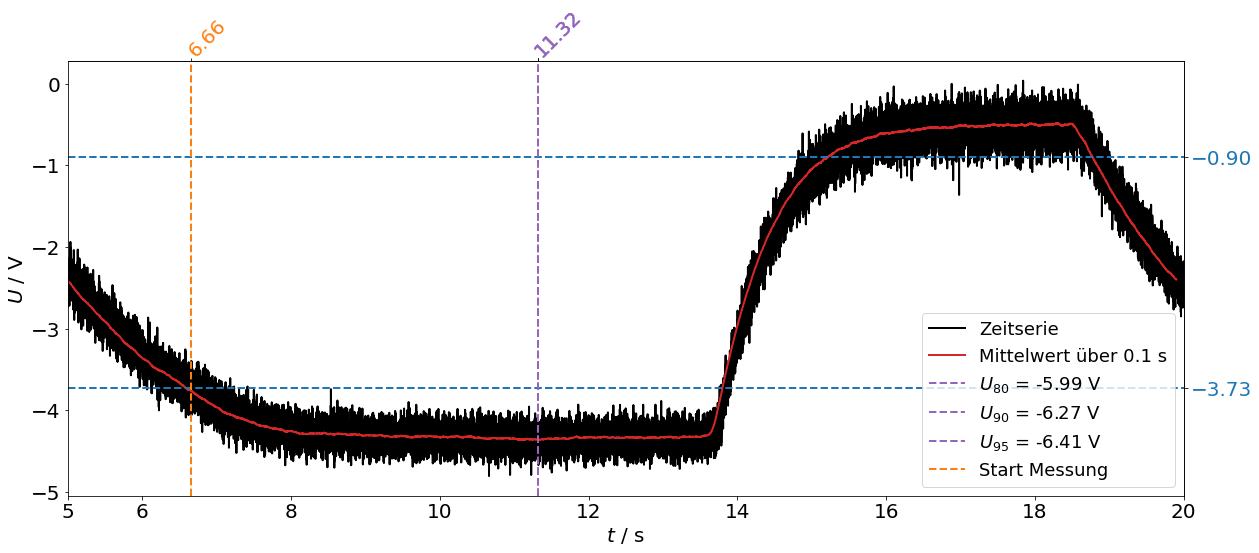

In [43]:
# Begrenze Zeitserie, das hilft später beim Schnittpunkt finden und vereinfacht Index->Zeit Konvertierung
data = data_backup
s_freq= 10000 # Sampling frequency
# Beginning and end of time series plot

tb = c(5)
te = c(20)
time = np.arange(0, len(data)/s_freq, 1/s_freq)
time = time[tb:te]
data = data[tb:te]

fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(time, data, c="black", label="Zeitserie")

t_avg = 1000
data_avg = moving_average(data, t_avg)
ax.plot(time[0:len(data_avg)], data_avg, c="C3", label=f"Mittelwert über {t_avg/s_freq} s")

# Hier muss man immer c(x) bei x, 5 abziehen, weil arrays ab 5 Sekunden anfangen und Index
# der Array sonst nicht richtig berechent wird
# Start
U_b = np.round(np.mean(data[0:c(9)-tb]),3)
ax.axhline(U_b, ls="--") # label= "$U_{start}$"+f" = {U_b}"

# End
U_e = np.round(np.mean(data[c(16)-tb:c(20)-tb]),3)
ax.axhline(U_e, ls="--") # label= "$U_{end}$"+f" = {U_e}"

# Fall until x%
U_delta = np.abs(U_e-U_b)
U_f_80 = U_b-U_delta*0.8
(_, t_f_80_idx) = find_nearest(data_avg, U_f_80)
ax.axvline(ci(t_f_80_idx+tb), ls="--", label= "$U_{80}$"+f" = {U_f_80:.2f} V", c="C4")

U_f_90 = U_b-U_delta*0.9
(_, t_f_90_idx) = find_nearest(data_avg, U_f_90)
ax.axvline(ci(t_f_90_idx+tb), ls="--", label= "$U_{90}$"+f" = {U_f_90:.2f} V", c="C4")

U_f_95 = U_b-U_delta*0.95
(_, t_f_95_idx) = find_nearest(data_avg, U_f_95)
ax.axvline(ci(t_f_95_idx+tb), ls="--", label= "$U_{95}$"+f" = {U_f_95:.2f} V", c="C4")

# First manual method
# ts = c(9.4) # Start of drop off/edge
# (t_f_0, t_f_0_idx) = find_nearest(data_avg[ts-tb:], U_b)
# ax.axvline(ci(t_f_0_idx+ts), ls="--", label= "$U_{drop}$"+f" = {U_f_0}", c="C1")

# Automatic --> First time difference to start value is greater than 1%
U_f_0 = U_b-U_delta*0.01
(_, t_f_0_idx) = find_nearest(data_avg, U_f_0)
ax.axvline(ci(t_f_0_idx+tb), ls="--", label= "Start Messung", c="C1")

ax.set_xticks(list(ax.get_xticks())+ [5])

ax_top = ax.secondary_xaxis("top")
t_f_0, t_80_f, t_90_f, t_95_f = cir(t_f_0_idx+tb), cir(t_f_80_idx+tb), cir(t_f_90_idx+tb), cir(t_f_95_idx+tb)
t_f_0_vec.append(t_f_0), t_80_f_vec.append(t_80_f-t_f_0), t_90_f_vec.append(t_90_f-t_f_0), t_95_f_vec.append(t_95_f-t_f_0)

extra_ticks_x1 = np.round([t_f_0, t_80_f, t_90_f, t_95_f],2)
ax_top.set_xticks(extra_ticks_x1)
ax_top.set_xticklabels(extra_ticks_x1, rotation=45, ha="left", va="center",rotation_mode="anchor")
ax_top.get_xticklabels()[0].set_color("C1")
for i in [1,2,3]:
    ax_top.get_xticklabels()[i].set_color("C4")


ax_right = ax.secondary_yaxis("right")
extra_ticks_y = np.round([U_b, U_e],2)
ax_right.set_yticks(extra_ticks_y)
for ax_label in ax_right.get_yticklabels():
    ax_label.set_color("C0")


ax.set_xlabel("$t$ / s")
ax.set_ylabel("$U$ / V")
ax.set_xlim(5,20)
ax.legend()
plt.savefig("Abb/Aufl_3_2_Zeitserie_fallend.png")

Steigende Flanke

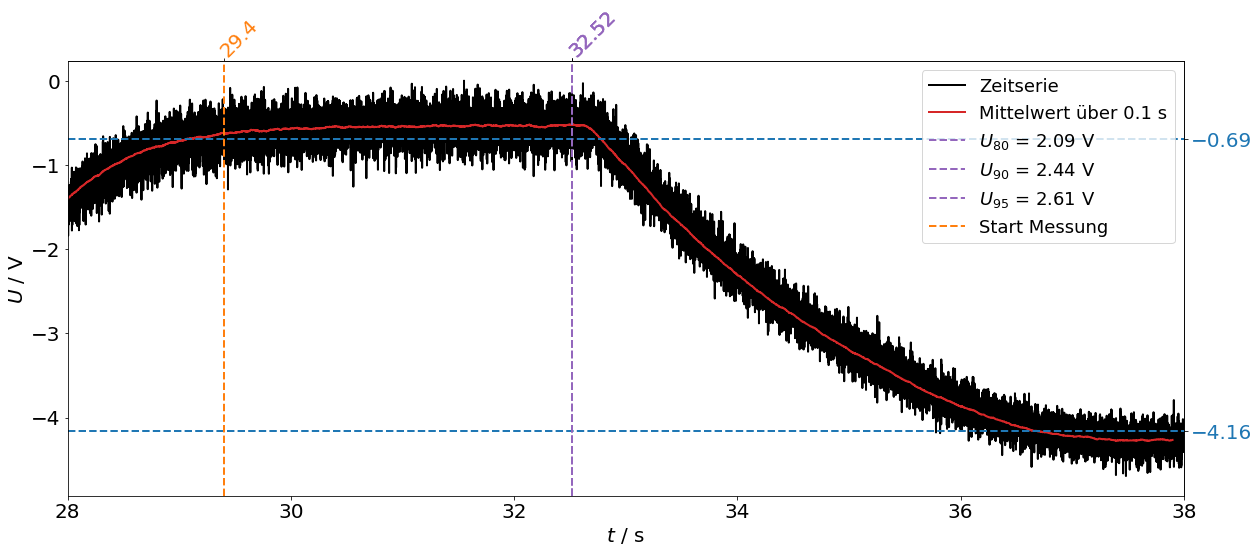

In [44]:
# Begrenze Zeitserie, das hilft später beim Schnittpunkt finden und vereinfacht Index->Zeit Konvertierung
data = data_backup
s_freq= 10000 # Sampling frequency
# Beginning and end of time series plot

tb = c(28)
te = c(38)
time = np.arange(0, len(data)/s_freq, 1/s_freq)
time = time[tb:te]
data = data[tb:te]

fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(time, data, c="black", label="Zeitserie")

t_avg = 1000
data_avg = moving_average(data, t_avg)
ax.plot(time[0:len(data_avg)], data_avg, c="C3", label=f"Mittelwert über {t_avg/s_freq} s")

# Hier muss man immer c(x) bei x, 5 abziehen, weil arrays ab 5 Sekunden anfangen und Index
# der Array sonst nicht richtig berechent wird
# Start
U_b = np.round(np.mean(data[28:c(31.8)-tb]),3)
ax.axhline(U_b, ls="--") # label= "$U_{start}$"+f" = {U_b}"

# End
U_e = np.round(np.mean(data[c(36)-tb:c(38)-tb]),3)
ax.axhline(U_e, ls="--") # label= "$U_{end}$"+f" = {U_e}"

# Rise until x%
U_delta = np.abs(U_e-U_b)
U_f_80 = U_b+U_delta*0.8
(t_f_80, t_f_80_idx) = find_nearest(data_avg, U_f_80)
ax.axvline(ci(t_f_80_idx+tb), ls="--", label= "$U_{80}$"+f" = {U_f_80:.2f} V", c="C4")

U_f_90 = U_b+U_delta*0.9
(t_f_90, t_f_90_idx) = find_nearest(data_avg, U_f_90)
ax.axvline(ci(t_f_90_idx+tb), ls="--", label= "$U_{90}$"+f" = {U_f_90:.2f} V", c="C4")

U_f_95 = U_b+U_delta*0.95
(t_f_95, t_f_95_idx) = find_nearest(data_avg, U_f_95)
ax.axvline(ci(t_f_95_idx+tb), ls="--", label= "$U_{95}$"+f" = {U_f_95:.2f} V", c="C4")

# Automatic --> First time difference to start value is greater than 1%
U_f_0 = U_b+U_delta*0.02
(t_f_0, t_f_0_idx) = find_nearest(data_avg, U_f_0)
ax.axvline(ci(t_f_0_idx+tb), ls="--", label= "Start Messung", c="C1")

ax_top = ax.secondary_xaxis("top")
t_f_0, t_80_f, t_90_f, t_95_f = cir(t_f_0_idx+tb), cir(t_f_80_idx+tb), cir(t_f_90_idx+tb), cir(t_f_95_idx+tb)
t_s_0_vec.append(t_f_0), t_80_s_vec.append(t_80_f-t_f_0), t_90_s_vec.append(t_90_f-t_f_0), t_95_s_vec.append(t_95_f-t_f_0)

extra_ticks_x2 = np.round([t_f_0, t_80_f, t_90_f, t_95_f],2)

ax_top.set_xticks(extra_ticks_x2)
ax_top.set_xticklabels(extra_ticks_x2, rotation=45, ha="left", va="center",rotation_mode="anchor")
ax_top.get_xticklabels()[0].set_color("C1")
for i in [1,2,3]:
    ax_top.get_xticklabels()[i].set_color("C4")

ax_right = ax.secondary_yaxis("right")
extra_ticks_y = np.round([U_b, U_e],2)
ax_right.set_yticks(extra_ticks_y)
for ax_label in ax_right.get_yticklabels():
    ax_label.set_color("C0")

# extra_ticks.extend(ax.get_xticks())
# plt.setp([tick.label2 for tick in ax.xaxis.get_major_ticks()], rotation=45,
#          ha="left", va="center",rotation_mode="anchor")

ax.set_xlabel("$t$ / s")
ax.set_ylabel("$U$ / V")
ax.set_xlim(28,38)
ax.legend()
plt.savefig("Abb/Aufl_3_2_Zeitserie_steigend.png")